# Building a Convolutional Neural Network for CIFAR-10 Classification

A complete, production-ready pipeline for image classification using TensorFlow/Keras.

**What you'll learn:**
- Data preprocessing and normalization
- Data augmentation techniques
- CNN architecture design with batch normalization
- Proper model compilation and training
- Evaluation and visualization

---

## 1. Setup and Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Load and Explore the Dataset

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Class names for CIFAR-10
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

print("Dataset shapes:")
print(f"  Training images: {x_train.shape}")
print(f"  Training labels: {y_train.shape}")
print(f"  Test images: {x_test.shape}")
print(f"  Test labels: {y_test.shape}")
print(f"\nPixel value range: [{x_train.min()}, {x_train.max()}]")
print(f"Data type: {x_train.dtype}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Dataset shapes:
  Training images: (50000, 32, 32, 3)
  Training labels: (50000, 1)
  Test images: (10000, 32, 32, 3)
  Test labels: (10000, 1)

Pixel value range: [0, 255]
Data type: uint8


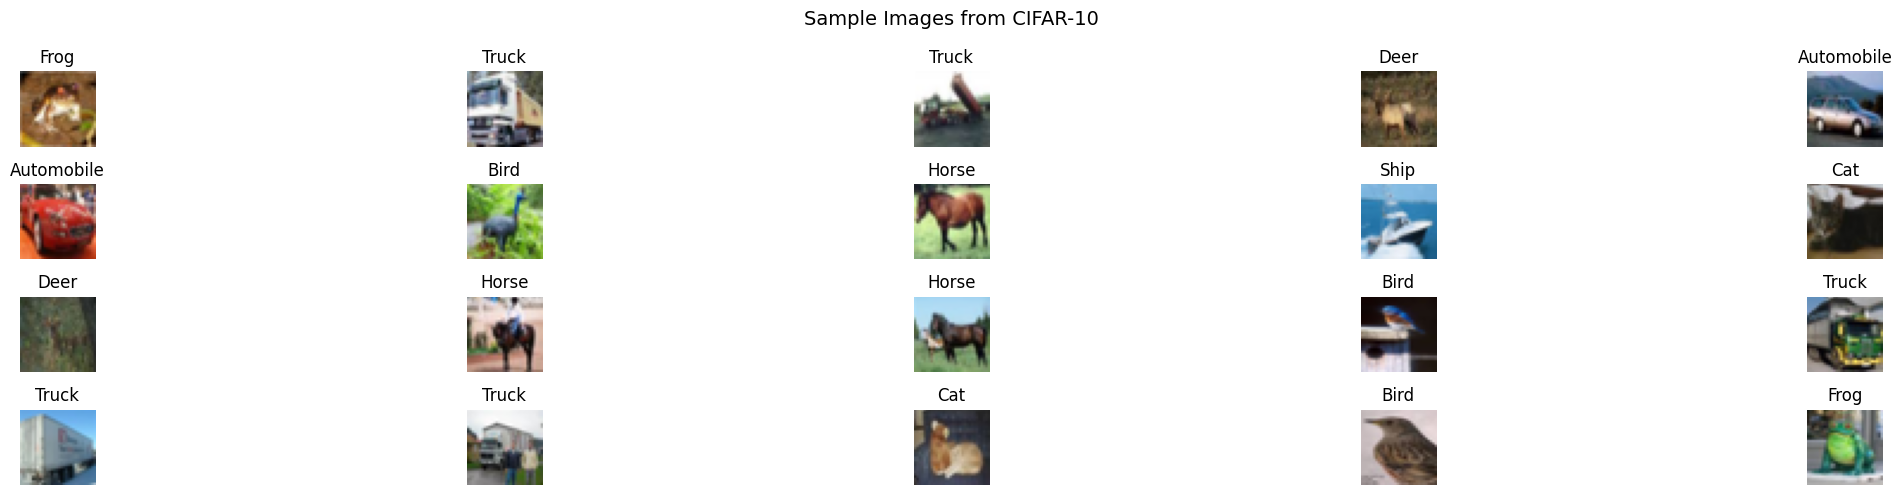

In [3]:
# Visualize some sample images
fig, axes = plt.subplots(4, 5, figsize=(25, 5))
fig.suptitle('Sample Images from CIFAR-10', fontsize=14)

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i])
    ax.set_title(class_names[y_train[i][0]])
    ax.axis('off')

plt.tight_layout()
plt.show()

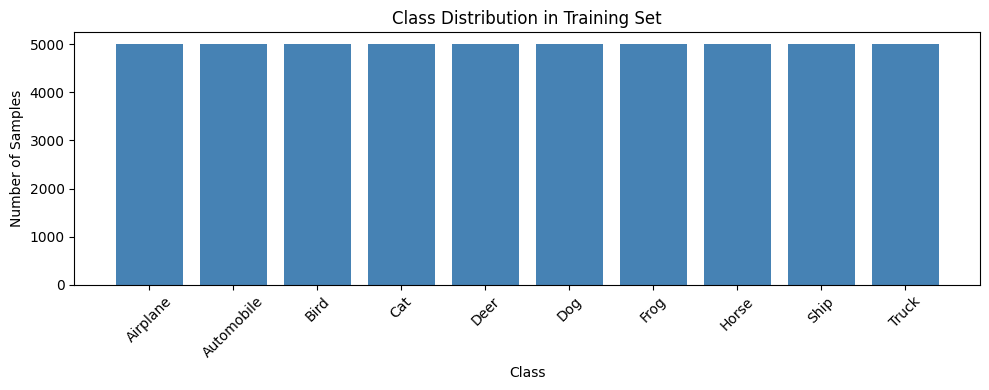


Class distribution is balanced (6000 samples per class).


In [4]:
# Check class distribution
unique, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(10, 4))
plt.bar(class_names, counts, color='steelblue')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nClass distribution is balanced (6000 samples per class).")

## 3. Data Preprocessing

Neural networks train faster and more stably when inputs are normalized to small values.

In [5]:
# Normalize pixel values from [0, 255] to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print(f"After normalization:")
print(f"  Pixel value range: [{x_train.min():.2f}, {x_train.max():.2f}]")
print(f"  Data type: {x_train.dtype}")
print(f"  Input shape for model: {x_train.shape[1:]}")

After normalization:
  Pixel value range: [0.00, 1.00]
  Data type: float32
  Input shape for model: (32, 32, 3)


In [6]:
# Create a validation split from training data
val_split = 0.2
val_size = int(len(x_train) * val_split)

# Shuffle indices
indices = np.random.permutation(len(x_train))
val_indices = indices[:val_size]
train_indices = indices[val_size:]

x_val = x_train[val_indices]
y_val = y_train[val_indices]
x_train_split = x_train[train_indices]
y_train_split = y_train[train_indices]

print(f"Training set: {x_train_split.shape[0]} samples")
print(f"Validation set: {x_val.shape[0]} samples")
print(f"Test set: {x_test.shape[0]} samples")

Training set: 40000 samples
Validation set: 10000 samples
Test set: 10000 samples


## 4. Data Augmentation

Data augmentation artificially expands the training set by applying random transformations. This significantly improves generalization and can boost accuracy by 5-10% on CIFAR-10.

In [7]:
# Define data augmentation layers
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),  # +/- 10% rotation (36 degrees)
    layers.RandomTranslation(0.1, 0.1),  # +/- 10% shift
    layers.RandomZoom(0.1),  # +/- 10% zoom
], name="data_augmentation")

print("Data augmentation pipeline created.")

Data augmentation pipeline created.


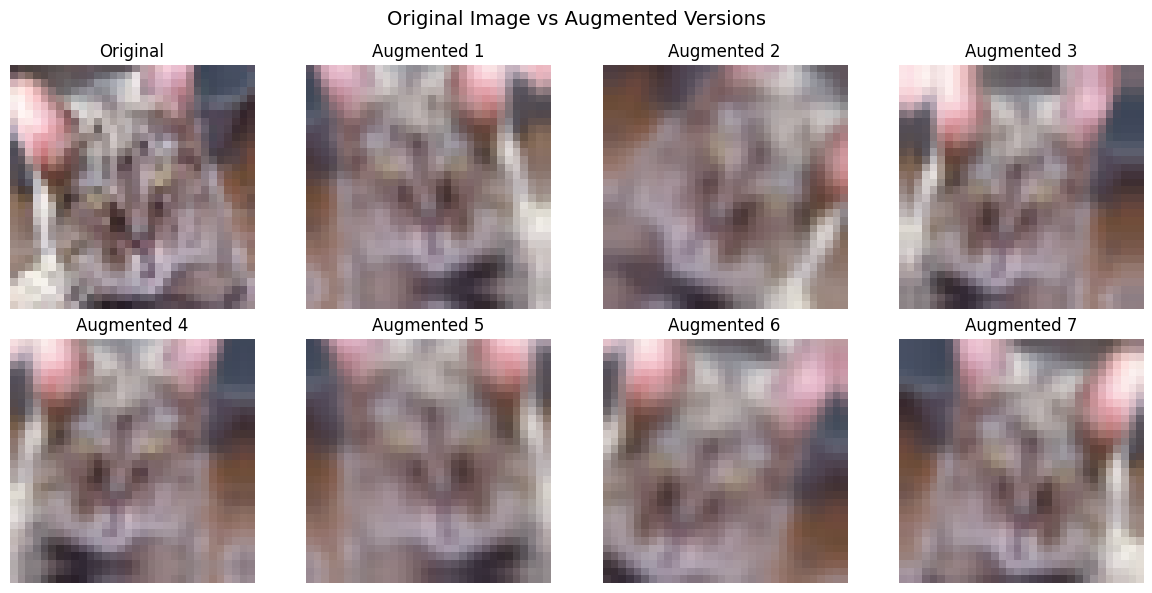

In [8]:
# Visualize augmentation effects on a single image
sample_image = x_train_split[5:6]  # Keep batch dimension

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('Original Image vs Augmented Versions', fontsize=14)

axes[0, 0].imshow(sample_image[0])
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

for i, ax in enumerate(axes.flat[1:]):
    augmented = data_augmentation(sample_image, training=True)
    ax.imshow(augmented[0])
    ax.set_title(f'Augmented {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## 5. Build the CNN Model

We'll build a three-block CNN with:
- Progressive filter increase (32 → 64 → 128)
- Batch normalization for training stability
- Dropout for regularization
- Data augmentation integrated into the model

In [9]:
def build_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    """
    Build a CNN model with data augmentation, batch normalization, and dropout.
    
    Architecture:
    - Input + Data Augmentation
    - Block 1: Conv(32) -> BatchNorm -> ReLU -> Conv(32) -> BatchNorm -> ReLU -> MaxPool -> Dropout
    - Block 2: Conv(64) -> BatchNorm -> ReLU -> Conv(64) -> BatchNorm -> ReLU -> MaxPool -> Dropout
    - Block 3: Conv(128) -> BatchNorm -> ReLU -> Conv(128) -> BatchNorm -> ReLU -> MaxPool -> Dropout
    - Flatten -> Dense(256) -> BatchNorm -> ReLU -> Dropout -> Output(10)
    """
    
    inputs = layers.Input(shape=input_shape)
    
    # Data augmentation (only active during training)
    x = data_augmentation(inputs)
    
    # Block 1: 32 filters
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 2: 64 filters
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 3: 128 filters
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    
    # Classification head
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # Output layer (no softmax - using from_logits=True in loss for numerical stability)
    outputs = layers.Dense(num_classes)(x)
    
    model = models.Model(inputs, outputs, name='cifar10_cnn')
    return model

# Build the model
model = build_cnn_model()
model.summary()

Model: "cifar10_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

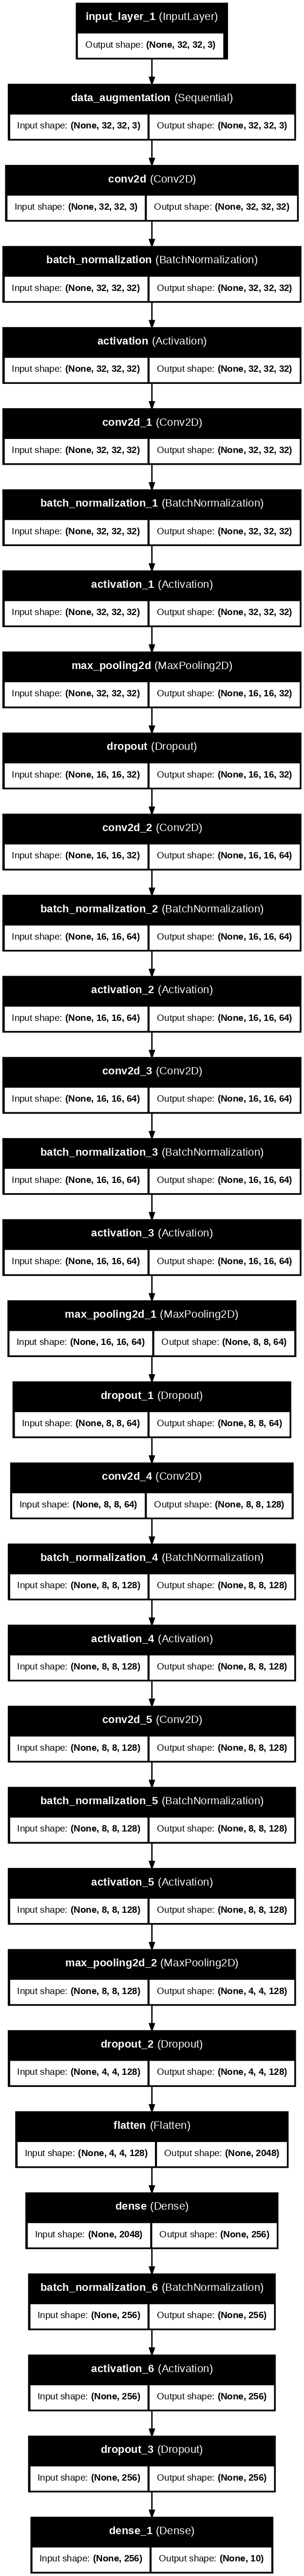

In [10]:
# Visualize model architecture
keras.utils.plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    dpi=100
)

from IPython.display import Image
Image('model_architecture.png')

## 6. Compile the Model

Key choices:
- **Optimizer**: Adam with default learning rate (0.001)
- **Loss**: Sparse categorical crossentropy with `from_logits=True` for numerical stability
- **Metrics**: Accuracy

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("Model compiled successfully.")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Loss: SparseCategoricalCrossentropy (from_logits=True)")
print(f"  Metrics: Accuracy")

Model compiled successfully.
  Optimizer: Adam (lr=0.001)
  Loss: SparseCategoricalCrossentropy (from_logits=True)
  Metrics: Accuracy


## 7. Define Callbacks

Callbacks help monitor training and prevent overfitting:
- **EarlyStopping**: Stop training if validation loss doesn't improve
- **ReduceLROnPlateau**: Reduce learning rate when stuck
- **ModelCheckpoint**: Save the best model

In [12]:
callbacks = [
    # Stop training if val_loss doesn't improve for 10 epochs
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate if val_loss plateaus
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    
    # Save best model
    keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured:")
print("  - EarlyStopping (patience=10)")
print("  - ReduceLROnPlateau (factor=0.5, patience=5)")
print("  - ModelCheckpoint (save best model)")

Callbacks configured:
  - EarlyStopping (patience=10)
  - ReduceLROnPlateau (factor=0.5, patience=5)
  - ModelCheckpoint (save best model)


## 8. Train the Model

In [13]:
# Training parameters
BATCH_SIZE = 64
EPOCHS = 50  # EarlyStopping will likely stop training earlier

print(f"Training configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max epochs: {EPOCHS}")
print(f"  Training samples: {len(x_train_split)}")
print(f"  Validation samples: {len(x_val)}")
print(f"  Steps per epoch: {len(x_train_split) // BATCH_SIZE}")
print("\nStarting training...\n")

Training configuration:
  Batch size: 64
  Max epochs: 50
  Training samples: 40000
  Validation samples: 10000
  Steps per epoch: 625

Starting training...



In [14]:
# Train the model
history = model.fit(
    x_train_split, y_train_split,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2930 - loss: 2.0635
Epoch 1: val_accuracy improved from -inf to 0.36940, saving model to best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.2932 - loss: 2.0626 - val_accuracy: 0.3694 - val_loss: 1.8944 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4640 - loss: 1.4728
Epoch 2: val_accuracy improved from 0.36940 to 0.54340, saving model to best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.4640 - loss: 1.4727 - val_accuracy: 0.5434 - val_loss: 1.2763 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5284 - loss: 1.3124
Epoch 3: val_accuracy improved from 0.54340 to 0.58590, saving model to best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5284 - loss: 1.3124 - val_accuracy: 0.5859 - val_loss: 1.1523 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 19m

In [27]:
# Save the trained model to Colab's working directory
import os

# Save location (Colab's current directory)
save_path = '/content/cifar10_model.keras'

# Save the model
model.save(save_path)

# Verify it was saved
if os.path.exists(save_path):
    file_size = os.path.getsize(save_path) / (1024 * 1024)  # Size in MB
    print(f"Model saved successfully!")
    print(f"Location: {save_path}")
    print(f"File size: {file_size:.2f} MB")
    print(f"\nTo see the file: Click the folder icon on the left sidebar in Colab")
else:
    print("Error: Model was not saved")

Model saved successfully!
Location: /content/cifar10_model.keras
File size: 9.48 MB

To see the file: Click the folder icon on the left sidebar in Colab


# Download the model to your computer
from google.colab import files

files.download('/content/cifar10_model.keras')
print("Check your Downloads folder!")

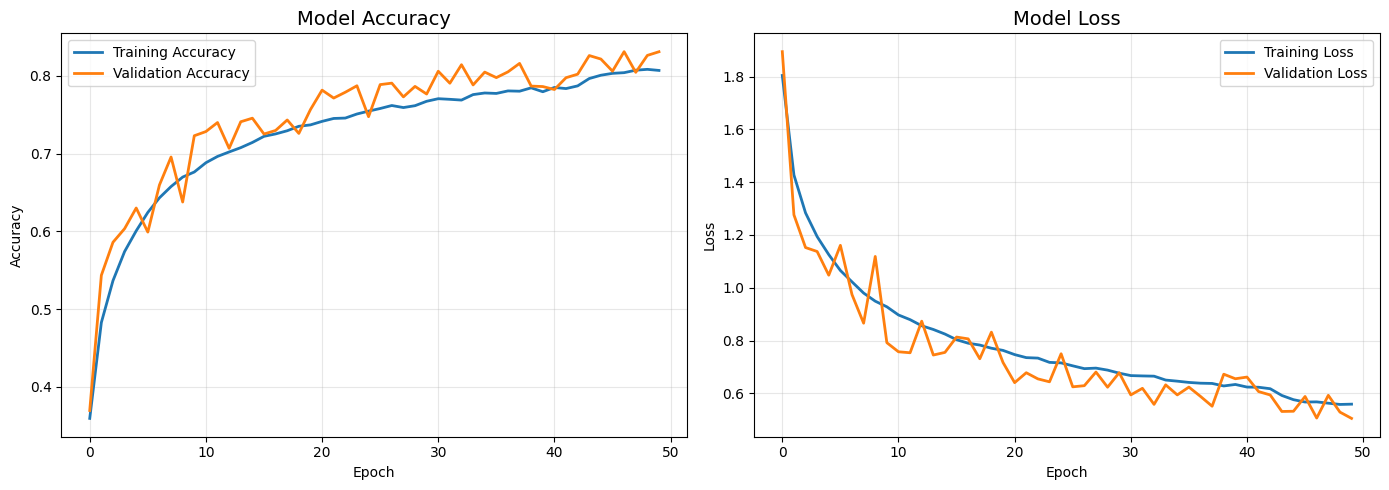


Final Training Accuracy: 0.8070
Final Validation Accuracy: 0.8311
Best Validation Accuracy: 0.8312


In [17]:
def plot_training_history(history):
    """Plot training and validation accuracy/loss curves."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title('Model Accuracy', fontsize=14)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=14)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print(f"\nFinal Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")

plot_training_history(history)

## 10. Evaluate on Test Set

In [18]:
# Load the best model
best_model = keras.models.load_model('best_model.keras')

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)

print(f"\n{'='*50}")
print(f"TEST SET RESULTS")
print(f"{'='*50}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"{'='*50}")


TEST SET RESULTS
Test Loss: 0.5240
Test Accuracy: 0.8260 (82.60%)


## 11. Detailed Analysis: Confusion Matrix and Classification Report

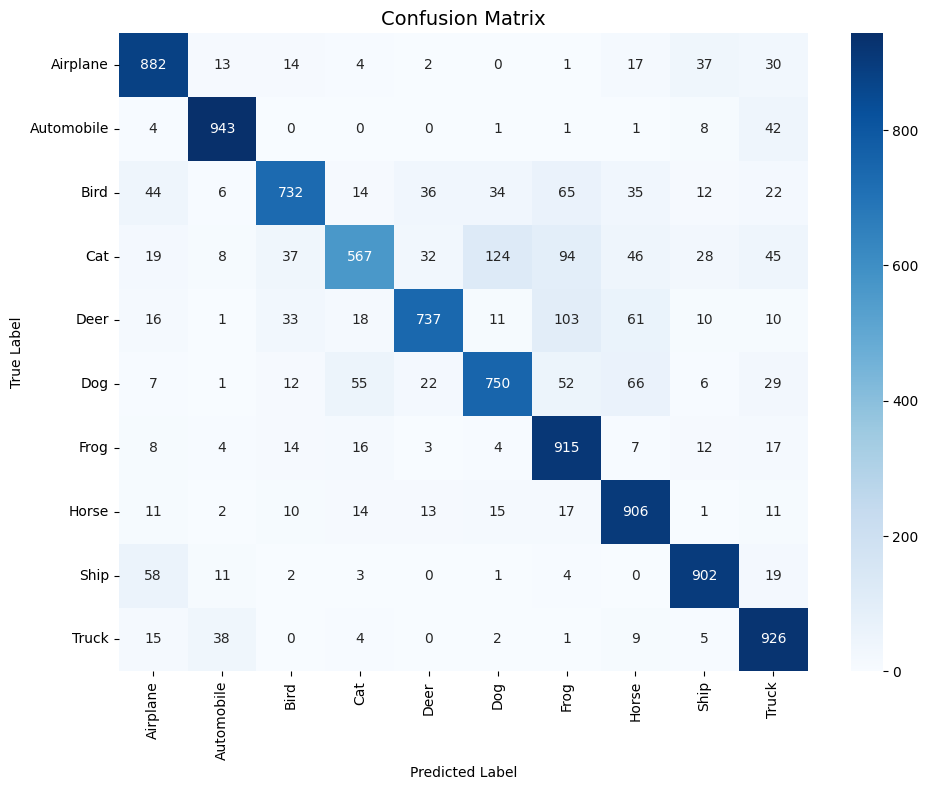

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
y_pred_logits = best_model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_logits, axis=1)
y_true = y_test.flatten()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [20]:
# Classification report
print("\nClassification Report:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

    Airplane       0.83      0.88      0.85      1000
  Automobile       0.92      0.94      0.93      1000
        Bird       0.86      0.73      0.79      1000
         Cat       0.82      0.57      0.67      1000
        Deer       0.87      0.74      0.80      1000
         Dog       0.80      0.75      0.77      1000
        Frog       0.73      0.92      0.81      1000
       Horse       0.79      0.91      0.84      1000
        Ship       0.88      0.90      0.89      1000
       Truck       0.80      0.93      0.86      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.82     10000
weighted avg       0.83      0.83      0.82     10000



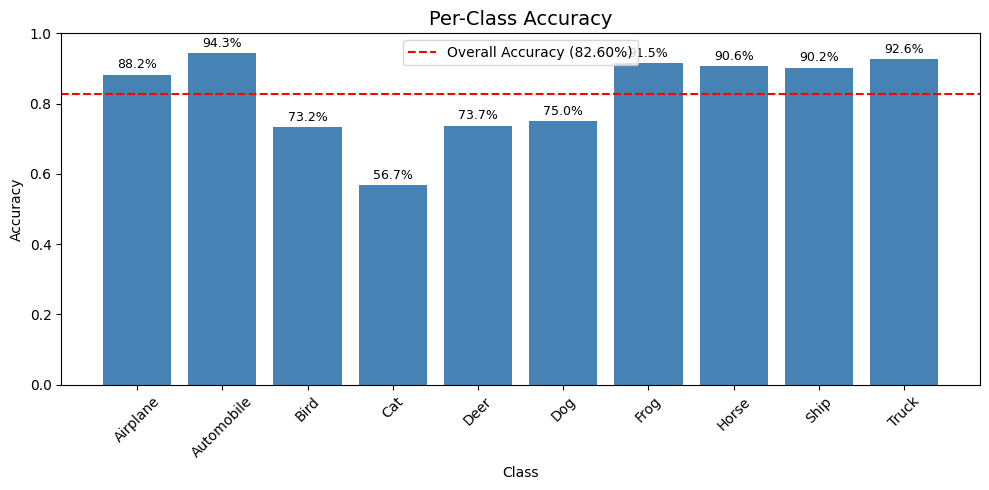

In [21]:
# Per-class accuracy visualization
class_accuracies = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(10, 5))
bars = plt.bar(class_names, class_accuracies, color='steelblue')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label=f'Overall Accuracy ({test_accuracy:.2%})')
plt.title('Per-Class Accuracy', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend()

# Add value labels on bars
for bar, acc in zip(bars, class_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.1%}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 12. Visualize Predictions

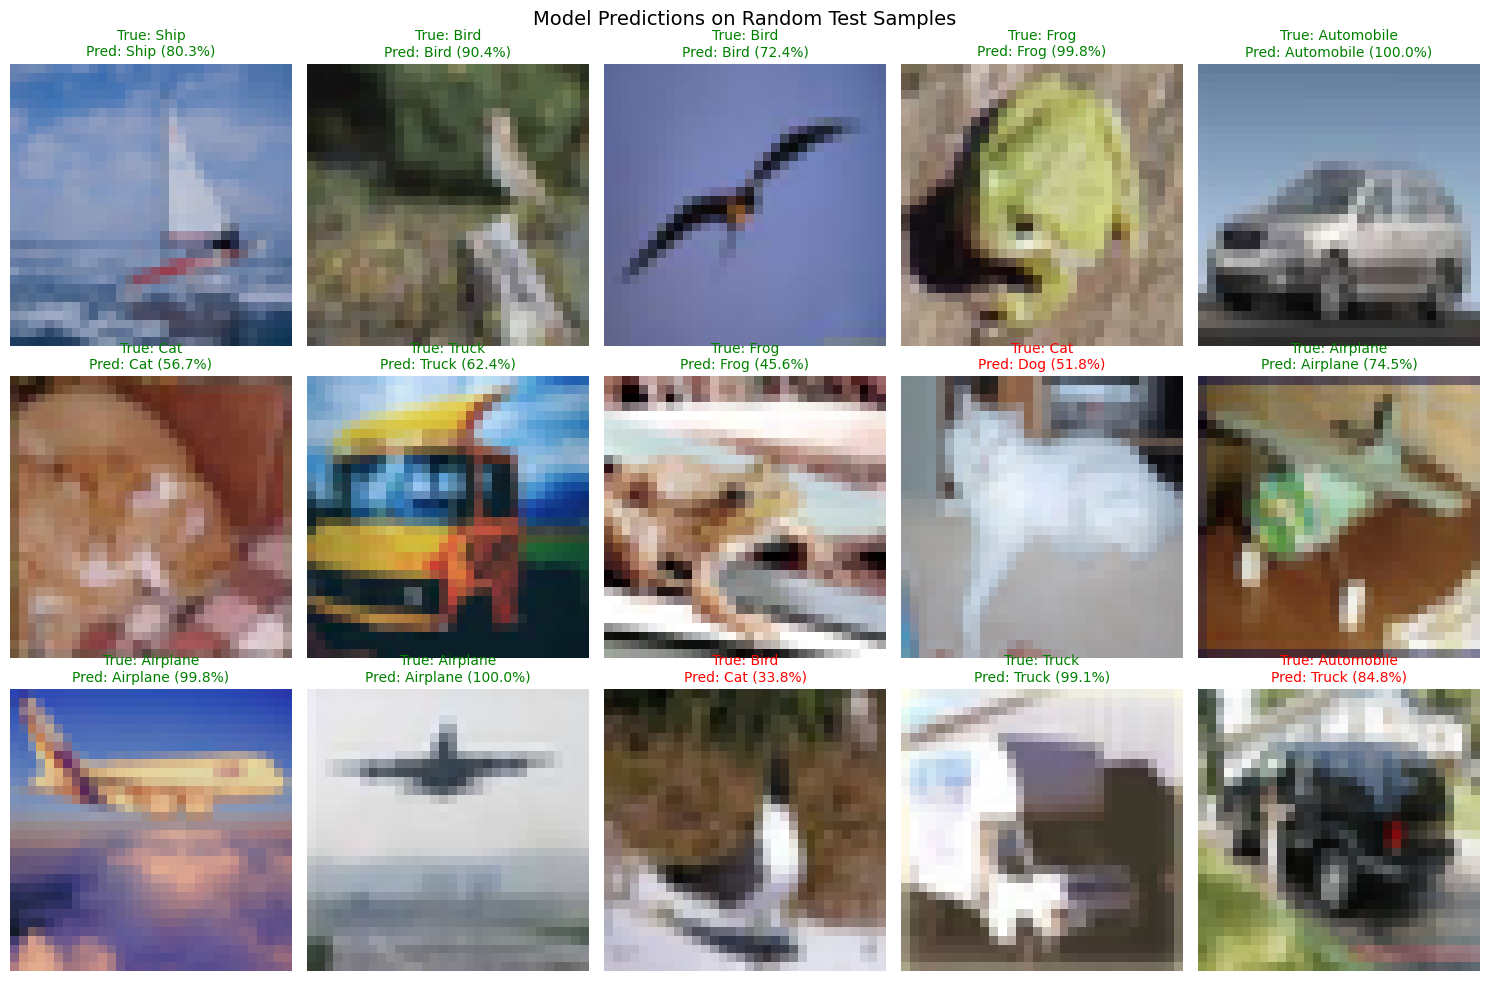

In [22]:
def visualize_predictions(model, x_test, y_test, class_names, num_samples=15):
    """Visualize model predictions on random test samples."""
    # Random sample indices
    indices = np.random.choice(len(x_test), num_samples, replace=False)
    
    # Get predictions
    samples = x_test[indices]
    true_labels = y_test[indices].flatten()
    pred_logits = model.predict(samples, verbose=0)
    pred_labels = np.argmax(pred_logits, axis=1)
    pred_probs = tf.nn.softmax(pred_logits).numpy()
    
    # Plot
    fig, axes = plt.subplots(3, 5, figsize=(15, 10))
    fig.suptitle('Model Predictions on Random Test Samples', fontsize=14)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i])
        true_label = class_names[true_labels[i]]
        pred_label = class_names[pred_labels[i]]
        confidence = pred_probs[i][pred_labels[i]] * 100
        
        # Color title based on correctness
        color = 'green' if true_labels[i] == pred_labels[i] else 'red'
        ax.set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
                     color=color, fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(best_model, x_test, y_test, class_names)

## 13. Visualize Misclassified Images

Total misclassified: 1740 out of 10000 (17.40%)


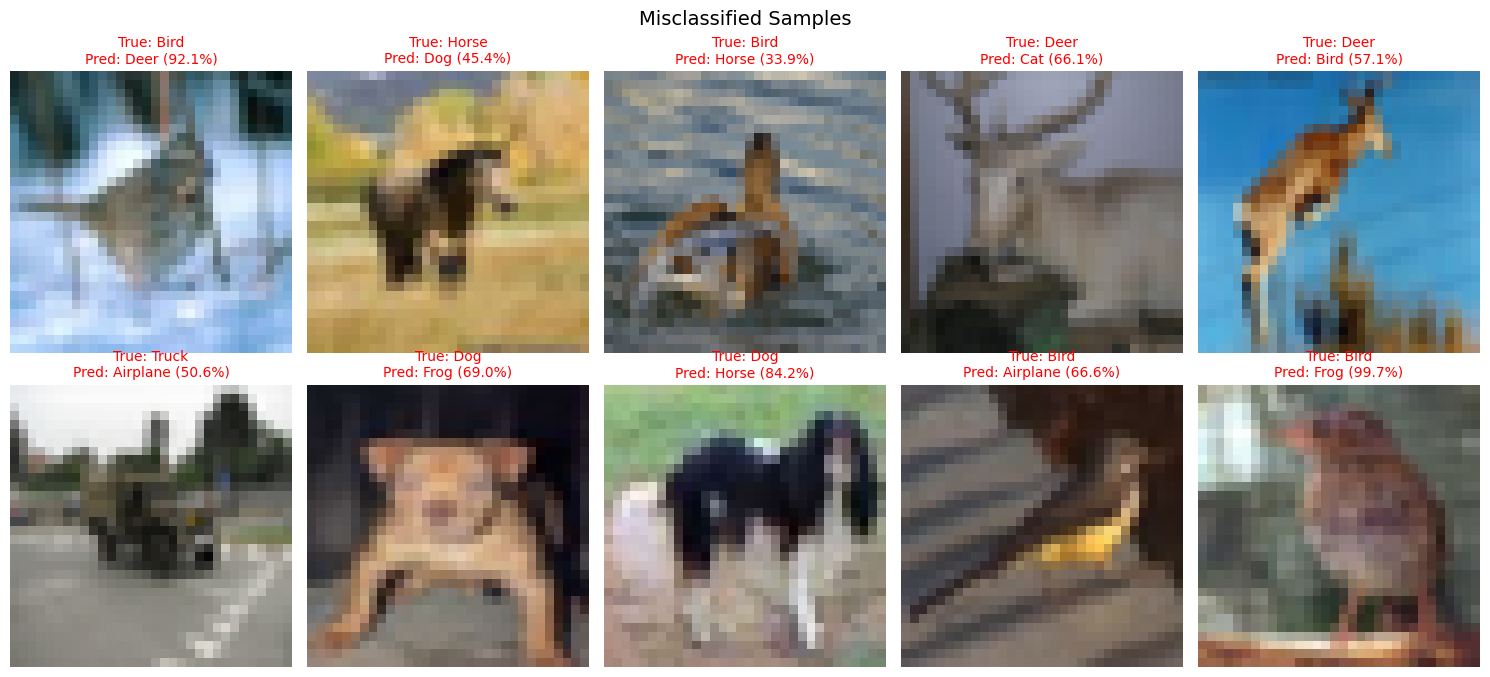

In [23]:
def visualize_misclassified(model, x_test, y_test, class_names, num_samples=10):
    """Visualize misclassified samples to understand model weaknesses."""
    # Get all predictions
    pred_logits = model.predict(x_test, verbose=0)
    pred_labels = np.argmax(pred_logits, axis=1)
    true_labels = y_test.flatten()
    pred_probs = tf.nn.softmax(pred_logits).numpy()
    
    # Find misclassified indices
    misclassified_idx = np.where(pred_labels != true_labels)[0]
    
    print(f"Total misclassified: {len(misclassified_idx)} out of {len(y_test)} ({len(misclassified_idx)/len(y_test)*100:.2f}%)")
    
    # Sample random misclassified images
    sample_idx = np.random.choice(misclassified_idx, min(num_samples, len(misclassified_idx)), replace=False)
    
    # Plot
    fig, axes = plt.subplots(2, 5, figsize=(15, 7))
    fig.suptitle('Misclassified Samples', fontsize=14)
    
    for i, ax in enumerate(axes.flat):
        idx = sample_idx[i]
        ax.imshow(x_test[idx])
        true_label = class_names[true_labels[idx]]
        pred_label = class_names[pred_labels[idx]]
        confidence = pred_probs[idx][pred_labels[idx]] * 100
        
        ax.set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
                     color='red', fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_misclassified(best_model, x_test, y_test, class_names)

## 14. Most Confused Class Pairs

In [24]:
# Find most confused pairs
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)

# Get top 5 confused pairs
top_k = 5
flat_indices = np.argsort(cm_no_diag.flatten())[-top_k:][::-1]
confused_pairs = [(flat_idx // 10, flat_idx % 10) for flat_idx in flat_indices]

print("Most Confused Class Pairs:")
print("="*50)
for i, (true_idx, pred_idx) in enumerate(confused_pairs):
    count = cm[true_idx, pred_idx]
    print(f"{i+1}. {class_names[true_idx]:12} → {class_names[pred_idx]:12}: {count} errors")

print("\nThese confusion patterns make intuitive sense:")
print("  - Cats and Dogs share similar shapes and textures")
print("  - Birds and Airplanes can have similar silhouettes")
print("  - Automobiles and Trucks share wheel-based structures")

Most Confused Class Pairs:
1. Cat          → Dog         : 124 errors
2. Deer         → Frog        : 103 errors
3. Cat          → Frog        : 94 errors
4. Dog          → Horse       : 66 errors
5. Bird         → Frog        : 65 errors

These confusion patterns make intuitive sense:
  - Cats and Dogs share similar shapes and textures
  - Birds and Airplanes can have similar silhouettes
  - Automobiles and Trucks share wheel-based structures


## 15. Save the Final Model

In [25]:
# Save in multiple formats

# Keras native format (recommended)
best_model.save('cifar10_cnn_final.keras')
print("Model saved as 'cifar10_cnn_final.keras'")

# Save model architecture as JSON
model_json = best_model.to_json()
with open('model_architecture.json', 'w') as f:
    f.write(model_json)
print("Architecture saved as 'model_architecture.json'")

# Save weights separately
best_model.save_weights('model_weights.weights.h5')
print("Weights saved as 'model_weights.weights.h5'")

Model saved as 'cifar10_cnn_final.keras'
Architecture saved as 'model_architecture.json'
Weights saved as 'model_weights.weights.h5'


## 16. How to Load and Use the Model Later

In [26]:
# Example: Load the model and make predictions
loaded_model = keras.models.load_model('cifar10_cnn_final.keras')

# Predict on a single image
sample_image = x_test[0:1]  # Keep batch dimension
prediction = loaded_model.predict(sample_image, verbose=0)
predicted_class = class_names[np.argmax(prediction)]
confidence = tf.nn.softmax(prediction[0]).numpy().max() * 100

print(f"Predicted class: {predicted_class} ({confidence:.2f}% confidence)")
print(f"True class: {class_names[y_test[0][0]]}")

Predicted class: Cat (60.39% confidence)
True class: Cat


---

## Summary

### What We Built
A CNN with:
- 3 convolutional blocks (32 → 64 → 128 filters)
- Batch normalization after each conv layer
- Data augmentation (flip, rotate, translate, zoom)
- Dropout regularization (25% in conv blocks, 50% before output)

### Key Techniques Used
1. **Normalization**: Scaled pixels to [0, 1]
2. **Data Augmentation**: Artificially expanded training set
3. **Batch Normalization**: Stabilized training
4. **from_logits=True**: Numerically stable loss computation
5. **Callbacks**: Early stopping, learning rate reduction, checkpointing

### Expected Performance
- With this architecture and training setup, you should achieve **82-87% test accuracy**
- State-of-the-art models (ResNet, EfficientNet) can reach 95%+ with more sophisticated techniques

### Next Steps
- Try transfer learning with pre-trained models (VGG16, ResNet50)
- Experiment with different optimizers (SGD with momentum)
- Implement learning rate schedules (cosine annealing)
- Explore more advanced augmentation (Cutout, Mixup, CutMix)